# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

### Мосалев Максим ИАД-7

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [84]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [86]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
7847,13335,58287,NaN,20-03-2020,Why and I cannot stress this enough the ACTUAL...,Positive
32198,43404,88356,London/Birmingham,13-04-2020,When thereÃÂs no queue at the supermarket an...,Negative
8736,14413,59365,"Manchester, UK",20-03-2020,$USDCAD experienced a sharp decline from yeste...,Positive
18678,26539,71491,"Nairobi, Kenya",25-03-2020,President Yoweri Museveni warns that crooks wh...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [87]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [88]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Positive': 1, 'Positive': 1, 'Negative': 0, 'Extremely Negative': 0})

In [89]:
df.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3416,7946,52898,West Yorkshire,18-03-2020,So self isolating for 14 days going to need fo...,0
25839,35445,80397,????,07-04-2020,Here s how CBS star and her team at Blinking O...,1
23592,32615,77567,"Montgomery, Alabama",05-04-2020,Do you remember the toilet paper shortage of 1...,0
4326,9059,54011,NaN,18-03-2020,Gold Prices Suffer As Severe Sell Off Hits The...,0
33422,44925,89877,"Kentucky, USA",14-04-2020,Toilet paper and sanitizer are almost nonexist...,1


Сбалансированы ли классы?

In [90]:
df['Sentiment'].value_counts()

1    18046
0    15398
Name: Sentiment, dtype: int64

**Ответ:** Количество класса позитивных твитов немного превышет класс негативных, но только на 15%, поэтому можно сказать, что классы сбалансированы. 

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [91]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [92]:
df.fillna('Unknown', inplace=True)

In [94]:
df.sample(6)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
17640,25251,70203,"Minnesota, USA",25-03-2020,The Plague Cometh We are Waiting Covid 19 It s...,0
6636,11862,56814,Birmingham UK,19-03-2020,More people are going to die of starvation tha...,0
27165,37110,82062,Unknown,07-04-2020,@judgeyourself99 @itsJeffTiedrich @realDonaldT...,0
19474,27508,72460,Sacramento,26-03-2020,?Calling all Californians?\r\r\n\r\r\nFood ban...,0
11095,17266,62218,"Toronto, Ontario",21-03-2020,@fordnation @Carolyn_Bennett We need a total s...,0
4688,9495,54447,Unknown,19-03-2020,NEW: All @ATT consumer home internet wireline ...,1


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [95]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [96]:
token_counts = {}

# Простая токенизация и подсчет встреч токенов
for text in train['OriginalTweet']:
    tokens = text.lower().split()  # Приведение к нижнему регистру и разделение по пробельным символам
    for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

Какой размер словаря получился?

In [97]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [98]:
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Вывод 10 самых популярных токенов
print("10 самых популярных токенов:")
for token, count in sorted_tokens[:10]:
    print(f"{token}: {count}")

10 самых популярных токенов:
the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** Именно эти токены в топе, потому что это так называемые стоп-слова - предлоги, частицы, междометия, которые часто используются в речи, но не несут большой смысловой нагрузки.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [99]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Удаление стоп-слов из словаря
filtered_token_counts = {token: count for token, count in token_counts.items() if token not in stop_words}

sorted_filtered_tokens = sorted(filtered_token_counts.items(), key=lambda x: x[1], reverse=True)

# Вывод новых топ-10 токенов
print("Топ-10 токенов после удаления стоп-слов:")
for token, count in sorted_filtered_tokens[:10]:
    print(f"{token}: {count}")

Топ-10 токенов после удаления стоп-слов:
#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79061\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Ответ:**  Теперь в топе оказались токены, которые несут смысловую нагрузку, а именно некие слова, уже нет предлогов и других служебных слов. 

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [100]:
print("20 самых непопулярных токенов:")
for token, count in sorted_filtered_tokens[-20:]:
    print(f"{token}: {count}")
print(f'Размер словаря: {len(sorted_filtered_tokens)}')

20 самых непопулярных токенов:
skellig: 1
coast!: 1
closer!): 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
playersãâ: 1
renewing: 1
wage!: 1
flew: 1
nothing...: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1
Размер словаря: 79584


**Ответ:** Как видим, в непопулярных токенах оказались ссылки, опечатки, специфичные сочетания слов, непопулярные хэштеги, отметки других пользователей. В принципе это просто шум и редко встречающиеся слова, их можно игнорировать или удалить из анализа.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [101]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

token_counts_tweet = {}
for text in train['OriginalTweet']:
    tokens = tokenizer.tokenize(text.lower())  # Токенизация текста с помощью TweetTokenizer и приведение к нижнему регистру
    for token in tokens:
        if token in token_counts_tweet:
            token_counts_tweet[token] += 1
        else:
            token_counts_tweet[token] = 1

# Вывод топ-10 популярных слов с использованием TweetTokenizer
sorted_tokens_tweet = sorted(token_counts_tweet.items(), key=lambda x: x[1], reverse=True)
print("Топ-10 популярных слов с использованием TweetTokenizer:")
for token, count in sorted_tokens_tweet[:10]:
    print(f"{token}: {count}")

Топ-10 популярных слов с использованием TweetTokenizer:
the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** Теперь в отдельные токены выделились знаки препинания, так как TweetTokenizer более точно токенизирует твиты, учитывая знаки препинания, скобочки, смайлики. 

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [102]:
from string import punctuation
noise = stopwords.words("english") + list(punctuation)
token_counts_tweet = {token: count for token, count in token_counts.items() if token not in noise}
sorted_tokens_tweet = sorted(token_counts_tweet.items(), key=lambda x: x[1], reverse=True)
print("Топ-10 популярных слов с использованием TweetTokenizer:")
for token, count in sorted_tokens_tweet[:10]:
    print(f"{token}: {count}")

Топ-10 популярных слов с использованием TweetTokenizer:
#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:** Теперь остались слова и хэштеги, но также и осталась html ссылка на амперсанд - &amp ;, что приравнивается к пунктуации, поэтому этот токен можно удалить. 

Удалите из словаря токены из одного символа с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [103]:
# Фильтрация токенов из одного символа с позицией в таблице Unicode 128 и более
f_token_counts_tweet = {token: count for token, count in token_counts_tweet.items() if len(token) > 1 or ord(token) < 128}

# Сортировка отфильтрованного словаря по значениям в убывающем порядке
sorted_f_tokens_tweet = sorted(f_token_counts_tweet.items(), key=lambda x: x[1], reverse=True)

# Вывод новых топ-10 и топ-20 токенов
print("Топ-10 самых популярных слов с использованием TweetTokenizer:")
for token, count in sorted_f_tokens_tweet[:10]:
    print(f"{token}: {count}")

print("\nТоп-20 самых непопулярных слов с использованием TweetTokenizer:")
for token, count in sorted_f_tokens_tweet[-20:]:
    print(f"{token}: {count}")
print(f'Размер словаря: {len(sorted_f_tokens_tweet)}')

Топ-10 самых популярных слов с использованием TweetTokenizer:
#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314

Топ-20 самых непопулярных слов с использованием TweetTokenizer:
skellig: 1
coast!: 1
closer!): 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
playersãâ: 1
renewing: 1
wage!: 1
flew: 1
nothing...: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1
Размер словаря: 79559


**Ответ:** Топ 10 остался таким же, в топ 20 непопулярных токенов также присутствуют редкие или уникальные токены, которые не являются стандартными словами в общем контексте; это специфические термины, малоупотребительные сокращения и названия, которые появились в тексте только один раз, непопулярные хэштеги, отметки и ссылки.  
Также видим, что размер словаря сократился, что означает, что TweetTokenizer дает более информативные результаты, так как он учитывает специфику твитов, хэштеги, пунктуацию и смайлики. 

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [104]:
import re

hashtag_counts =  {}

# Регулярное выражение для поиска хештегов
pattern = re.compile(r'#\w+')

for text in train['OriginalTweet']:
    hashtags = pattern.findall(text)  # Поиск хештегов в тексте
    for hashtag in hashtags:
        if hashtag in hashtag_counts:
            hashtag_counts[hashtag] += 1
        else:
            hashtag_counts[hashtag] = 1

# Вывод топ-10 популярных хештегов
sorted_hashtags = sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True)
print("Топ-10 популярных хештегов:")
for hashtag, count in sorted_hashtags[:10]:
    print(f"{hashtag}: {count}")

Топ-10 популярных хештегов:
#coronavirus: 7166
#COVID19: 1847
#Covid_19: 1464
#Coronavirus: 1285
#COVID2019: 927
#COVID: 685
#toiletpaper: 657
#covid19: 569
#CoronaCrisis: 426
#CoronaVirus: 351


**Ответ:** Хэштеги отражают тематику или тенденции, которые активно обсуждаются в социальной сети в данный момент.
Некоторые из них могут быть связаны с актуальными событиями, кампаниями или движениями.  
Как мы видим почти все хэштеги связаны с пандемией коронавируса, так как эти твиты были собраны за период, когда эта тема была актуальна. 

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [105]:
link_counts = {}

# Регулярное выражение для поиска ссылок на сайт https://t.co
link_pattern = re.compile(r'https://t.co/\w+')

# Подсчет встреч ссылок
for text in train['OriginalTweet']:
    links = link_pattern.findall(text)  # Поиск ссылок в тексте
    for link in links:
        if link in link_counts:
            link_counts[link] += 1
        else:
            link_counts[link] = 1

# Вывод топ-10 популярных ссылок
sorted_links = sorted(link_counts.items(), key=lambda x: x[1], reverse=True)
print("Топ-10 популярных ссылок на сайт https://t.co:")
for link, count in sorted_links[:10]:
    print(f"{link}: {count}")


Топ-10 популярных ссылок на сайт https://t.co:
https://t.co/oXA7SWtoNd: 5
https://t.co/gP3EusapL8: 4
https://t.co/DefTruI1PfÃ: 3
https://t.co/WrLHYzIzAA: 3
https://t.co/kuwIpF1KQW: 3
https://t.co/zjNRx6dKKN: 3
https://t.co/3GBBDpdjat: 3
https://t.co/e2ZNXajPre: 3
https://t.co/CATKegAyOY: 3
https://t.co/G63RP042HO: 3


**Ответ:** Популярность ссылок несравнима с популярностью хештегов (5 против 7166), поэтому информация о ссылках на конкретную страницу в данном случае не полезна.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [106]:
def custom_tokenizer(text):
    text = text.lower()   # Приведение текста к нижнему регистру

    tokenizer = TweetTokenizer()
    
    tokens = tokenizer.tokenize(text)
    
    noise = stopwords.words('english') + list(punctuation)
    
    # Регулярное выражение для поиска ссылок на сайт t.co
    link_pattern = re.compile(r'https://t.co/\w+')
    
    # Фильтрация токенов
    filtered_tokens = []
    for token in tokens:
        # Удаление стоп-слов, пунктуации, токенов из одного символа и ссылок на сайт t.co
        if token not in noise and (len(token) > 1 or ord(token) < 128) and not link_pattern.match(token):
            filtered_tokens.append(token)
    
    return filtered_tokens

In [107]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

45309


**Ответ:** В начале получили размер словаря 79755, сейчас размер 45309. Таким образом, используя написанный токанайзер custom_tokenizer, учитывающий специфику твитов, мы смогли убрать шум и сократили словарь на 44%. 

Посмотрим на какой-нибудь конкретный твитт:

In [109]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [110]:
new_text_vectorized = cv.transform([train.iloc[ind]['OriginalTweet']])
feature_names = cv.get_feature_names_out()

# Поиск самого важного токена
max_component_index = new_text_vectorized.toarray().argmax()
most_important_token = feature_names[max_component_index]

# Поиск самого неважного токена
min_component_index = new_text_vectorized.toarray().argmin()
min_component = new_text_vectorized.toarray().min()
least_important_token = feature_names[min_component_index]

print("Самый важный токен:", most_important_token)
print("Самый неважный токен (компонента вектора без учета 0):", least_important_token)

Самый важный токен: #coronavirusoutbreak
Самый неважный токен (компонента вектора без учета 0): ###covid-19


**Ответ:** В этом случае определился хэштег #coronavirusoutbreak как самый важный токен, по этому токену скорее можно что-то сказать о настроении твита, однако в твите есть более явные токены для определения настроения.   
CountVectorizer просто считает количество вхождений каждого токена в документ. Веса токенов определяются только их частотой в документе, поэтому этот векторайзер плохо подходит для выявления важных токенов.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TfidfVectorizer с использованием custom_tokenizer в качестве токенизатора
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

X_tfidf = tfidf_vectorizer.fit_transform(train['OriginalTweet'])

# Векторизация нового текста
new_text_vectorized_tfidf = tfidf_vectorizer.transform([train.iloc[ind]['OriginalTweet']])
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Поиск самого важного токена
max_component_index_tfidf = new_text_vectorized_tfidf.toarray().argmax()
most_important_token_tfidf = feature_names_tfidf[max_component_index_tfidf]

# Поиск самого неважного токена
min_component_index_tfidf = new_text_vectorized_tfidf.toarray().argmin()
min_component_tfidf = new_text_vectorized_tfidf.toarray().min()
least_important_token_tfidf = feature_names_tfidf[min_component_index_tfidf]

print("Самый важный токен (TfidfVectorizer):", most_important_token_tfidf)
print("Самый неважный токен (TfidfVectorizer, компонента вектора без учета 0):", least_important_token_tfidf)

Самый важный токен (TfidfVectorizer): brainless
Самый неважный токен (TfidfVectorizer, компонента вектора без учета 0): ###covid-19


**Ответ:** Здесь выделился токен brainless как самый важный, этот токен чаще встретится в негативных твитах, поэтому с данным векторайзером лучше выделяется важныф токен.  
TfidfVectorizer вычисляет веса токенов с использованием tf-idf. Это показатель, который учитывает не только частоту токена в документе, но и обратную частоту токена во всех документах коллекции. Это позволяет выделить ключевые слова, которые часто встречаются в конкретном документе, но редко встречаются в остальных документах коллекции. Так, данный векторайзер лучше всго определяет важные токены.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [112]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [113]:
ind = 8221
new_text_vectorized_tfidf = tfidf_vectorizer.transform([train.loc[ind]['OriginalTweet']])
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
# Поиск самого важного токена
max_component_index_tfidf = new_text_vectorized_tfidf.toarray().argmax()
most_important_token_tfidf = feature_names_tfidf[max_component_index_tfidf]

print("Самый важный токен (TfidfVectorizer):", most_important_token_tfidf)

Самый важный токен (TfidfVectorizer): thank


**Ответ:** Здесь выделился токен thank как самый важен, этот токен почти всегда встречается в положительных твитах, так как люди выражают благодарность. 

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [43]:
X_count = cv.fit_transform(train['OriginalTweet'])
X_tfifd = tfidf_vectorizer.fit_transform(train['OriginalTweet'])
X_count_test = cv.transform(test['OriginalTweet'])
X_tfifd_test = tfidf_vectorizer.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']
print(len(cv.vocabulary_))

45309


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_count, y_train)
pred = clf.predict(X_count_test)
print(accuracy_score(y_test, pred))

clf.fit(X_tfifd, y_train)
pred = clf.predict(X_tfifd_test)
print(accuracy_score(y_test, pred))

0.8672513454255532
0.8531991229818616


**Ответ:** В данном случае логистическая регрессия с CountVectorizer показала себя лучше, чем с TfidfVectorizer. Получается, для данной задачи представление текста с использованием частоты встречаемости слов (CountVectorizer) оказалось более информативным, чем представление с использованием весов TF-IDF.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [45]:
from nltk.stem import SnowballStemmer
def custom_stem_tokenizer(text):
    text = text.lower()   # Приведение текста к нижнему регистру
    stemmer = SnowballStemmer('english')
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    noise = stopwords.words('english') + list(punctuation)
    
    # Регулярное выражение для поиска ссылок на сайт t.co
    link_pattern = re.compile(r'https://t.co/\w+')
    
    # Фильтрация токенов
    filtered_tokens = []
    for token in tokens:
        # Удаление стоп-слов, пунктуации, токенов из одного символа и ссылок на сайт t.co
        if token not in noise and (len(token) > 1 or ord(token) < 128) and not link_pattern.match(token):
            token = stemmer.stem(token)
            filtered_tokens.append(token)
    
    return filtered_tokens

In [46]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [47]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_v = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_count = cv.fit_transform(train['OriginalTweet'])
X_tfidf = tfidf_v.fit_transform(train['OriginalTweet'])

X_count_test = cv.transform(test['OriginalTweet'])
X_tfidf_test = tfidf_v.transform(test['OriginalTweet'])

print(len(cv.vocabulary_))

36653


**Ответ** Размер словаря заметно уменьшился, так как стемминг удаляет суффиксы, окончания у слов, чтобы привести их к основной форме, за счет приведения однокоренных слов к одной основе и уменьшается размер словаря. 

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [48]:
clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_count, y_train)
pred = clf.predict(X_count_test)
print(accuracy_score(y_test, pred))

clf.fit(X_tfifd, y_train)
pred = clf.predict(X_tfifd_test)
print(accuracy_score(y_test, pred))

0.8672513454255532
0.8531991229818616


**Ответ:** На этих данных качество не поменялось. Есть смысл в применении стемминга, так как благодаря ему мы заметно сократили словарь, из-за чего вычисления ускорятся, и в нашем случае качество не поменялось при меньшем словаре.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [49]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

C:\Users\79061\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [50]:
X_count = cv_df.transform(train['OriginalTweet'])

X_count_test = cv_df.transform(test['OriginalTweet'])

clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_count, y_train)
pred = clf.predict(X_count_test)
print(accuracy_score(y_test, pred))

0.8680486346422165


**Ответ:** Параметр max_df в CountVectorizer используется для фильтрации токенов, которые встречаются слишком часто в документах. max_df принимает относительно низкое значение, чтобы исключить чрезмерно частые токены, в результате чего сокращается размер словаря. Это позволит сохранить только наиболее информативные и разнообразные токены.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [51]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00045
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

C:\Users\79061\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [52]:
X_count = cv_df.transform(train['OriginalTweet'])

X_count_test = cv_df.transform(test['OriginalTweet'])

clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_count, y_train)
pred = clf.predict(X_count_test)
print(accuracy_score(y_test, pred))

0.8680486346422165


**Ответ:** Установка min_df позволяет определить минимальное количество документов, в которых токен должен встречаться, чтобы быть включенным в словарь. В  нашем случае мы получили маленькое значение данного параметра, что означает, что в словарь могут быть включены токены, которые встречаются в очень небольшом количестве документов. При этом мы получили такое же достаточно хорошее значение accuracy.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_count)
X_test_scaled = scaler.transform(X_count_test)

clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.8446282639027307


C:\Users\79061\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


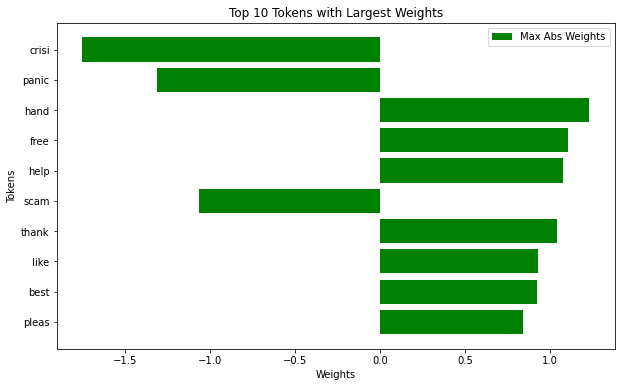

In [54]:
import matplotlib.pyplot as plt

# Получение индексов токенов с наибольшими по модулю весами
feature_names = cv_df.get_feature_names()
top_indices = np.argsort(np.abs(clf.coef_[0]))[-10:]

# Получение токенов с наибольшими и наименьшими по модулю весами
top_tokens = [feature_names[i] for i in top_indices]

# Получение весов соответствующих токенов
top_weights = [clf.coef_[0][i] for i in top_indices]

# Построение barplot для токенов с наибольшими и наименьшими по модулю весами
plt.figure(figsize=(10, 6))
plt.barh(top_tokens, top_weights, color='green', label='Max Abs Weights')
plt.xlabel('Weights')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Largest Weights')
plt.legend()
plt.show()

**Ответ:** При отскалированных значениях качество модели ухудшилось, однако теперь по весам можно определить токены, которые сильнее всех влияют на окрас твита. Как видно из гистограммы такие слова как crisis, panic, scam предают твиту негативный окрас, а слова hand, best, thank, help - положительный, это корректные и логичные выводы из результатов модели. 

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [119]:
print(df['UserName'].nunique())
print(df['ScreenName'].nunique())
print(df.shape[0])

33444
33444
33444


**Ответ:** Все значения UserName и ScreenName уникальны, поэтому они совершенно бесполезны. И в любом случае поля Name такого рода ведут к переобучению модели и не дадут ни какой пользы на новых данных. Так, UserName и ScreenName не полезны.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [57]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

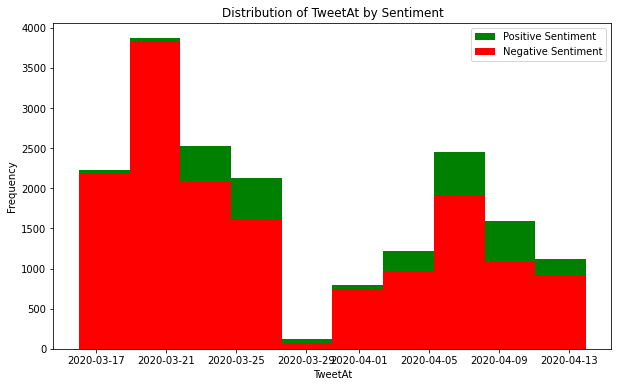

In [58]:
positive_tweets = df[df['Sentiment'] == 1]
negative_tweets = df[df['Sentiment'] == 0]

# Построение гистограммы с разделением по цвету
plt.figure(figsize=(10, 6))
plt.hist(positive_tweets['TweetAt'], color='green', label='Positive Sentiment')
plt.hist(negative_tweets['TweetAt'], color='red', label='Negative Sentiment')
plt.xlabel('TweetAt')
plt.ylabel('Frequency')
plt.title('Distribution of TweetAt by Sentiment')
plt.legend()
plt.show()

Нужно понимать для какой цели создается модель, если для анализа твитов за этот же период, то мы видим, что в некоторые даты заметно преобладают позитивные твиты, что может быть полезно для модели. Однако если цель - анализ будущих твитов, то полная дата совершенно бесполезный признак так как в новых данных точно не встретятся эти значения. Возможно будет полезным выделить только месяцы из даты и проанализировать их.   
Однако в качестве эксперимента попробуем добавить к признакам информацию о времени и посмотрим качество модели.

In [67]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_time_train = encoder.fit_transform(train['TweetAt'].values.reshape(-1, 1))
encoded_time_test = encoder.transform(test['TweetAt'].values.reshape(-1, 1))

X_train_ex = sp.hstack([X_train_scaled, encoded_time_train])
X_test_ex = sp.hstack([X_test_scaled, encoded_time_test])
# Обучение логистической регрессии на расширенной матрице признаков
clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_train_ex, y_train)

y_pred_ex = clf.predict(X_test_ex)

# Оценка качества модели
accuracy_ex = accuracy_score(y_test, y_pred_ex)
print("Accuracy with extended features:", accuracy_ex)

Accuracy with extended features: 0.8428343631652382


**Ответ:** Качество ухудшилось, поэтому признак TweetAt бесполезен.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [59]:
df['Location'].nunique()

10465

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

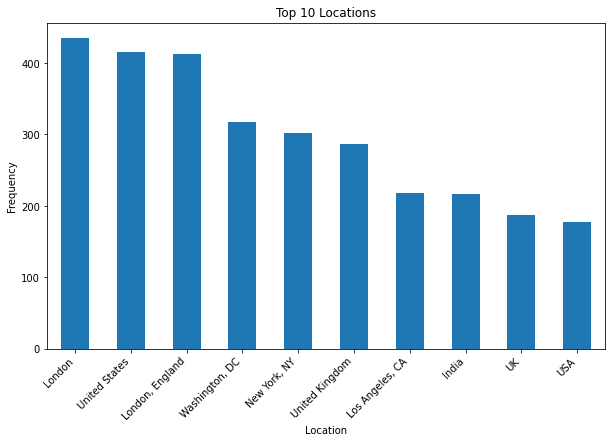

In [60]:
location_counts = df['Location'].value_counts()

# Исключение местоположения 'Unknown'
location_counts = location_counts.drop('Unknown', errors='ignore')

# Выбор топ-10 местоположений
top_10_locations = location_counts.head(10)

# Построение гистограммы
plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Top 10 Locations')
plt.xticks(rotation=45, ha='right')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Количество уникальных категорий в новом признаке WiderLocation: 6203


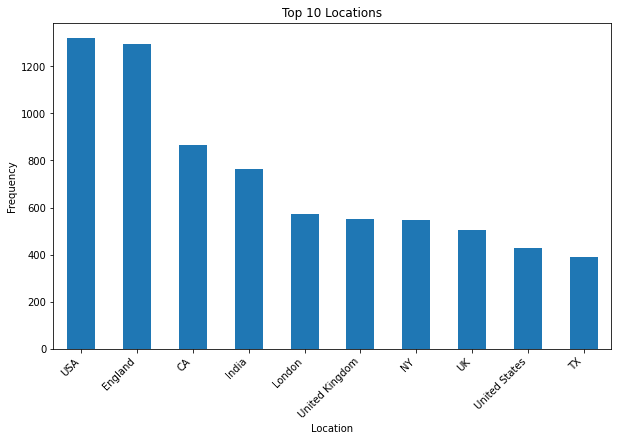

In [61]:
# Функция для извлечения более широкого местоположения
def extract_wider_location(location):
    if ',' in location:
        return location.split(',')[1].strip()
    else:
        return location.strip()

# Создание нового признака WiderLocation
df['WiderLocation'] = df['Location'].apply(extract_wider_location)
train['WiderLocation'] = train['Location'].apply(extract_wider_location)
test['WiderLocation'] = test['Location'].apply(extract_wider_location)

# Подсчет количества уникальных категорий в новом признаке
unique_wider_locations = df['WiderLocation'].nunique()

print("Количество уникальных категорий в новом признаке WiderLocation:", unique_wider_locations)

location_counts = df['WiderLocation'].value_counts().drop('Unknown', errors='ignore')

# Выбор топ-10 местоположений
top_10_locations = location_counts.head(10)

# Построение гистограммы
plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Top 10 Locations')
plt.xticks(rotation=45, ha='right')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [62]:
from sklearn.preprocessing import OneHotEncoder

# Получение количества вхождений каждого местоположения
location_counts = df['WiderLocation'].value_counts()

# Выбор только тех местоположений, которые встречаются более одного раза
popular_locations = location_counts[location_counts > 1].index.tolist()
popular_location_data = df[df['WiderLocation'].isin(popular_locations)]

locations_train = train[train['WiderLocation'].isin(popular_locations)]

# Кодирование признака WiderLocation с помощью OHE
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_wider_location = encoder.fit_transform(popular_location_data['WiderLocation'].values.reshape(-1, 1))
num_encoded_columns = encoded_wider_location.shape[1]
print("Количество уникальных значений местоположений, встречающихся более одного раза:", num_encoded_columns)

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_locations_train = encoder.fit_transform(locations_train['WiderLocation'].values.reshape(-1, 1))
encoder_locations_train = encoder.transform(train['WiderLocation'].values.reshape(-1, 1))
encoder_locations_test = encoder.transform(test['WiderLocation'].values.reshape(-1, 1))

Количество уникальных значений местоположений, встречающихся более одного раза: 1319


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [68]:
import scipy.sparse as sp
X_train_extended = sp.hstack([X_train_scaled, encoder_locations_train])
X_test_extended = sp.hstack([X_test_scaled, encoder_locations_test])
# Обучение логистической регрессии на расширенной матрице признаков
clf = LogisticRegression(max_iter=400, random_state=56)
clf.fit(X_train_extended, y_train)

y_pred_extended = clf.predict(X_test_extended)

# Оценка качества модели
accuracy_extended = accuracy_score(y_test, y_pred_extended)
print("Accuracy with extended features:", accuracy_extended)

Accuracy with extended features: 0.8440302969902332


**Ответ:** Качество немного ухудшилось (на 0.0006), поэтому можно обойтись без этого признака, то есть признак WiderLocation бесполезен.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

Попробуем изменить модели и посмотрим на их accuracy. 

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.3, random_state=0)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.3)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение модели градиентного бустинга
model = xgb.XGBClassifier()
model.fit(X_train_tfidf, y_train)

# Предсказание на тестовом наборе
y_pred = model.predict(X_test_tfidf)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8201116204903328


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.3, random_state=0)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение модели случайного леса
model = RandomForestClassifier()
model.fit(X_train_tfidf, y_train)

# Предсказание на тестовом наборе
y_pred = model.predict(X_test_tfidf)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8024715965716563


Получили качества ниже, чем у логистической регрессии.   

In [120]:
def custom_stem_tokenizer2(text):
    text = text.lower()   # Приведение текста к нижнему регистру
    stemmer = SnowballStemmer('english')
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    noise = stopwords.words('english') + list(punctuation)
    
    # Регулярное выражение для поиска ссылок на сайт t.co
    link_pattern = re.compile(r'https://t.co/\w+')
    ll = re.compile(r'@\w+')
    
    # Фильтрация токенов
    filtered_tokens = []
    for token in tokens:
        # Удаление стоп-слов, пунктуации, токенов из одного символа и ссылок на сайт t.co
        if token not in noise and len(token) > 1 and not link_pattern.match(token) and token != '&amp;' and not ll.match(token):
            token = stemmer.stem(token)
            filtered_tokens.append(token)
    
    return filtered_tokens

In [127]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer2,
                        max_df=0.3
                        ).fit(
                            train['OriginalTweet']
                            )
X_count = cv_df.transform(train['OriginalTweet'])

X_count_test = cv_df.transform(test['OriginalTweet'])

clf = LogisticRegression(max_iter=400, random_state=0)
clf.fit(X_count, y_train)
pred = clf.predict(X_count_test)
print(accuracy_score(y_test, pred))

C:\Users\79061\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8703408411401236


Таким образом, улучшив токенайзер, наилучший результат получился при данной модели.